In [1]:
import pandas as pd
import tensorflow as tf 
import numpy as np 
from matplotlib import pyplot as plt
import sys, time, imageio, h5py, skimage, glob
from tensorflow.keras.layers import Conv2D, Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with h5py.File('/content/drive/My Drive/TomoGAN-tutorial/dataset/demo-dataset.h5', 'r') as h5fd:
    ns_img_train = h5fd['train_ns'][:]
    gt_img_train = h5fd['train_gt'][:]

    ns_img_test = h5fd['test_ns'][:]
    gt_img_test = h5fd['test_gt'][:]

ns_img_train.shape, gt_img_train.shape, ns_img_test.shape, gt_img_test.shape

In [2]:
with h5py.File('dataset/demo-dataset.h5', 'r') as h5fd:
    ns_img_train = h5fd['train_ns'][:]
    gt_img_train = h5fd['train_gt'][:]

    ns_img_test = h5fd['test_ns'][:]
    gt_img_test = h5fd['test_gt'][:]

ns_img_train.shape, gt_img_train.shape, ns_img_test.shape, gt_img_test.shape

((512, 128, 128), (512, 128, 128), (32, 128, 128), (32, 128, 128))

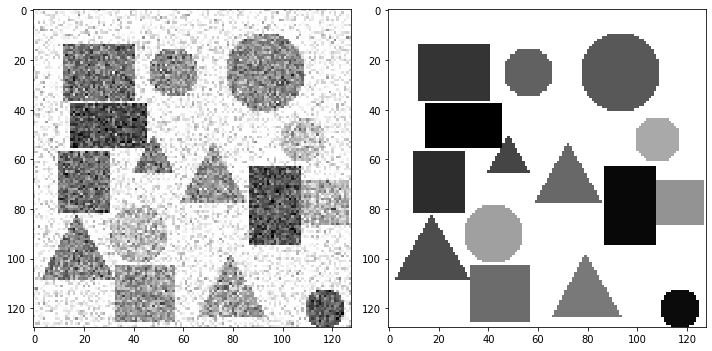

In [3]:
vis_idx = 0

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(ns_img_train[vis_idx], cmap='gray')
plt.subplot(122)
plt.imshow(gt_img_train[vis_idx], cmap='gray')
plt.tight_layout()
plt.show(); plt.close()

![alt text](./img/dncnn.png "Title")

In [4]:
def cnn4dn_mdl(input_shape, layer_width=(8, 16, 8, 4)):
    inputs = Input(shape=input_shape)
    _tmp   = inputs
    for _lw in layer_width:
        _tmp = Conv2D(filters=_lw, kernel_size=3, padding='same', activation='relu')(_tmp)
        
    # output layer, 1 kernel/channel, no activation
    _out = Conv2D(filters=1, kernel_size=3, padding='same', activation=None)(_tmp)
    
    return tf.keras.models.Model(inputs, _out)

In [5]:
# create a model
tf.keras.backend.clear_session()
dn_mdl = cnn4dn_mdl(input_shape=(None, None, 1), layer_width=(8, 16, 8, 4))
dn_mdl.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 8)     80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 4)     292       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 1)     37        
Total params: 2,737
Trainable params: 2,737
Non-trainable params: 0
____________________________________________________

### why are there 80 paras in the 1st layer? 80 = (3 x 3 x 1 + 1) x 8
### why 584 in the 2nd layers? 1168 = (3 x 3 x 8 + 1) * 16

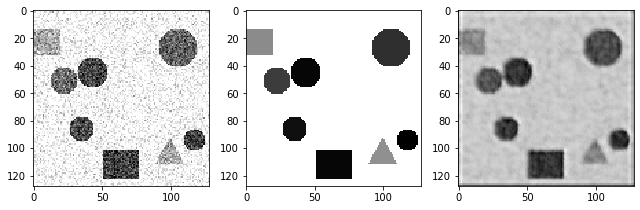

In [39]:
mbsz = 8 # batch size

mdl_optimizer = tf.train.AdamOptimizer(learning_rate=3e-4)

for ep in range(1):
    for _sidx in range(0, ns_img_train.shape[0]-mbsz, mbsz):
        mb_X = ns_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] # add an empty dimension to form 4D tensor
        mb_y = gt_img_train[_sidx:_sidx+mbsz,:,:,np.newaxis] 

        with tf.GradientTape() as gd_tape:
            gd_tape.watch(dn_mdl.trainable_variables)
            
            dn_img = dn_mdl(mb_X, training=True) # try to denoise
            
            # compute the loss, use MSE here
            loss_mse = tf.losses.mean_squared_error(dn_img, mb_y)

            # compute the derivative of loss function of the model weights, i.e., gradient of weight
            gradients= gd_tape.gradient(loss_mse, dn_mdl.trainable_variables)
            
            # update neural network weights
            mdl_optimizer.apply_gradients(zip(gradients, dn_mdl.trainable_variables))

#     print('Epoch: %04d, Loss: %.2f' % (ep, 1+loss_mse))
    if ep == 0:
        val_X, val_y = ns_img_test[-1:,:,:,np.newaxis], gt_img_test[-1:]
        ns4vis = val_X.squeeze()
        gt4vis = val_y.squeeze()
    dn_img_val = dn_mdl.predict(val_X).squeeze()
    
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.imshow(ns4vis, cmap='gray'); 
    plt.subplot(132)
    plt.imshow(gt4vis, cmap='gray');
    plt.subplot(133)
    plt.imshow(dn_img_val, cmap='gray'); 
    plt.tight_layout(); plt.show(); plt.close()

In [ ]:
## use keras wrapper to fit

## Then how to save the precious model and share with others

In [14]:
dn_mdl.save("dn-mdl.h5", include_optimizer=False)

## Then, how to load a model to do the job 

![alt text](./img/loss-demo.png "Title")